In [19]:
from scipy.ndimage import shift
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from copy import deepcopy

from sklearn.datasets import fetch_openml, make_moons
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.linear_model import SGDClassifier, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

# 문제 1) 숫자 MNIST 이미지의 분류 문제

#### 데이터셋 준비

In [2]:
X, y = fetch_openml("mnist_784", return_X_y=True, as_frame=False)

#### 훈련세트, 테스트세트 나누기

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#### 4 방향으로 한 픽셀만큼 이동 시킨 이미지를 반환하는 함수

In [4]:
def make_4direction_shifted_image(image):
    arr = [shift(image, s, cval=0).flatten() for s in [[0, 1], [0, -1], [1, 0], [-1, 0]]]
    return np.stack(arr)

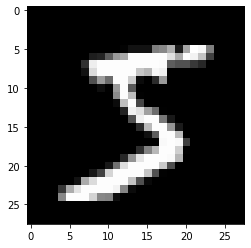

In [5]:
plt.imshow(X[0].reshape(28, 28), cmap='gray')

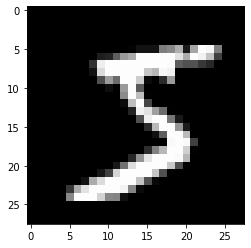

In [6]:
plt.imshow(make_4direction_shifted_image(X[0].reshape(28, 28))[0].reshape(28, 28), cmap='gray')

#### 훈련 세트에 있는 각 이미지에 대해 네 개의 이동된 복사본(방향마다 한 개씩)을 만들어 훈련 세트에 추가

In [7]:
import os
import pickle

if os.path.exists('X_train_extended.sav') and os.path.exists('y_train_extended.sav'):
    X_train_extended, y_train_extended = pickle.load('X_train_extended.sav'), pickle.load('y_train_extended.sav')
    
else:
    X_train_extended, y_train_extended = deepcopy(X_train), deepcopy(y_train)

    for i in tqdm(range(len(X_train))):
        image = X_train[i].reshape(28, 28)
        X_train_extended = np.append(X_train_extended, make_4direction_shifted_image(image), axis=0)
        y_train_extended = np.append(y_train_extended, np.repeat(y_train[i], 4))

    with open('X_train_extended.sav', 'wb') as f:
        pickle.dump(X_train_extended, f)

    with open('y_train_extended.sav', 'wb') as f:
        pickle.dump(y_train_extended, f)

  0%|          | 0/49000 [00:00<?, ?it/s]

#### 확장된 훈련 세트로 숫자 5를 판변하는 이진 분류기 훈련

In [9]:
y_train_extended_5 = (y_train_extended == '5')
y_test_5 = (y_test == '5')

In [12]:
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train_extended, y_train_extended_5)

SGDClassifier(random_state=42)

#### 테스트 세트에서 모델 성능 측정
결과 설명
1. 정확도 
   - 정확도는 95.5%로 단순히 False(5가 아님)만 반환하는 모델보다 더 성능이 뛰어나다
2. 혼잡 행렬의 결과
    - 정밀도는 95%, 재현율은 99%이다
    - 이는 모델이 5라고 예측한 데이터 중에서 5% 정도는 실제로 정답이 아님을 뜻한다
    - 그리고 실제로 데이터가 5이면 99% 확률로 정답을 맞춘다는 뜻이다

In [23]:
y_pred = sgd_clf.predict(X_test)
acc = accuracy_score(y_test_5, y_pred)
cm = confusion_matrix(y_test_5, y_pred)
ps = precision_score(y_test_5, y_pred, pos_label=0)
rs = recall_score(y_test_5, y_pred, pos_label=0)
print(f'accuracy : {acc}')
print(f'precision : {ps}')
print(f'recall : {rs}')
print(f'confusion matrix\n{cm}')

accuracy : 0.955
precision : 0.9579649370989743
recall : 0.9940757051483695
confusion matrix
[[18961   113]
 [  832  1094]]


# 2) 회귀문제

#### 데이터 생성
$ y = x^3 - x^2 $ with noise

In [ ]:
X = np.linspace(-1, 1, 400).reshape(-1, 1) + 0.1 * np.random.randn(400, 1) 
y = X ** 3 - X ** 2

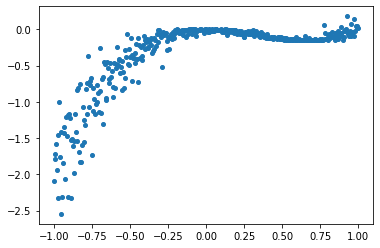

In [ ]:
plt.scatter(np.linspace(-1, 1, 400), y, s=16)
plt.show()

#### 정규방정식

In [ ]:
X_b = np.c_[np.ones((400, 1)), X]

In [ ]:
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[-0.34110124],
       [ 0.62737373]])

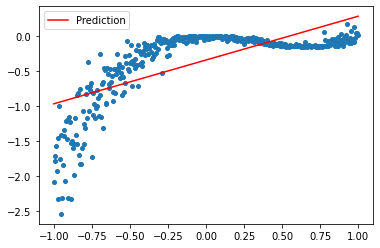

In [ ]:
plt.scatter(np.linspace(-1, 1, 400), y, s=16)
plt.plot(np.linspace(-1, 1, 400), theta_best[0] + theta_best[1] * np.linspace(-1, 1, 400), '-r', label='Prediction')
plt.legend()
plt.show()

#### 배치경사하강법

In [ ]:
alpha = .1
n_iter = 1000
m = 400

theta = np.random.randn(2, 1)

for iter in range(n_iter):
    gradients = (2 / m) * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - alpha * gradients

theta

array([[-0.34110124],
       [ 0.62737373]])

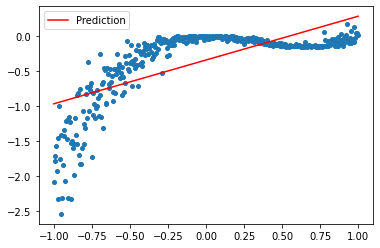

In [ ]:
plt.scatter(np.linspace(-1, 1, 400), y, s=16)
plt.plot(np.linspace(-1, 1, 400), theta[0] + theta[1] * np.linspace(-1, 1, 400), '-r', label='Prediction')
plt.legend()
plt.show()

#### PolynomialFeatures 와 LinearRegression

In [ ]:
poly_features = PolynomialFeatures(degree=3, include_bias=True)
X_poly = poly_features.fit_transform(X)
X[0]

array([-1.01858154])

In [ ]:
X_poly[0]

array([ 1.        , -1.01858154,  1.03750836, -1.05678687])

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([-7.21644966e-16]),
 array([[ 0.00000000e+00, -4.24296718e-16, -1.00000000e+00,
          1.00000000e+00]]))

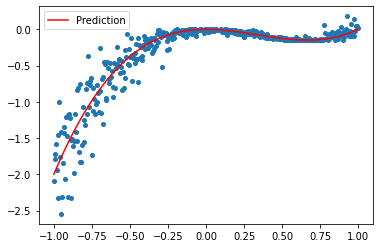

In [ ]:
X_new = poly_features.transform(np.linspace(-1, 1, 400).reshape(-1, 1))
plt.scatter(np.linspace(-1, 1, 400), y, s=16)
plt.plot(np.linspace(-1, 1, 400), lin_reg.predict(X_new) , '-r', label='Prediction')
plt.legend()
plt.show()

# 3) 비선형 SVM 분류 문제

#### 데이터셋 준비

In [ ]:
X, y = make_moons(n_samples=200, noise=0.1, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

#### RBF 커널 SVM 분류 모델 학습 후 훈련세트, 검증세트, 테스트세트 성능 비교

In [ ]:
poly_kernel_svm_clf = Pipeline([('scaler', StandardScaler()),
                               ('svm_clf', SVC(kernel='rbf', degree=3, coef0=1, C=5, gamma=1))])
poly_kernel_svm_clf.fit(X_train, y_train)

pred_y = poly_kernel_svm_clf.predict(X_train)
print(f'train accuracy : {accuracy_score(y_train, pred_y)}')

pred_y = poly_kernel_svm_clf.predict(X_test)
print(f'test accuracy : {accuracy_score(y_test, pred_y)}')

scores = cross_val_score(poly_kernel_svm_clf, X, y, scoring='accuracy', cv=5)
print(f'cross validation accuracy mean : {np.mean(scores)}')

train accuracy : 1.0
test accuracy : 1.0
cross validation accuracy mean : 0.9949999999999999


#### 시각화 준비

In [ ]:
def plot_dataset(X, y, axes, set_label=True):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'bs')
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], 'g^')
    plt.axis(axes)
    plt.grid(True, which='both')
    if set_label:
        plt.xlabel(r'$x_1$')
        plt.ylabel(r'$x_2$')


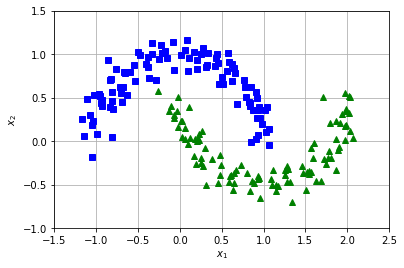

In [ ]:
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

In [ ]:
def plot_predictions(clf, axes):
    x1range = np.linspace(axes[0], axes[1], 100)
    x2range = np.linspace(axes[2], axes[3], 100)
    x1mesh, x2mesh = np.meshgrid(x1range, x2range)
    X = np.c_[x1mesh.ravel(), x2mesh.ravel()]
    y_pred = clf.predict(X).reshape(x1mesh.shape)
    y_decision = clf.decision_function(X).reshape(x1mesh.shape)
    plt.contourf(x1mesh, x2mesh, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x1mesh, x2mesh, y_decision, cmap=plt.cm.brg, alpha=0.1)

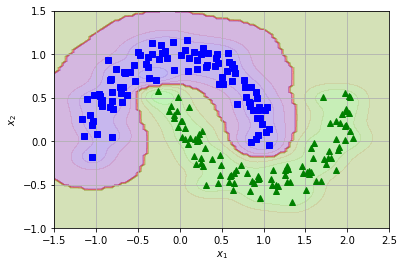

In [ ]:
plot_predictions(model, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

#### RBF 커널 SVM의 매개변수 $C$와 $\gamma$ 설정에 따른 결정 경계 시각화

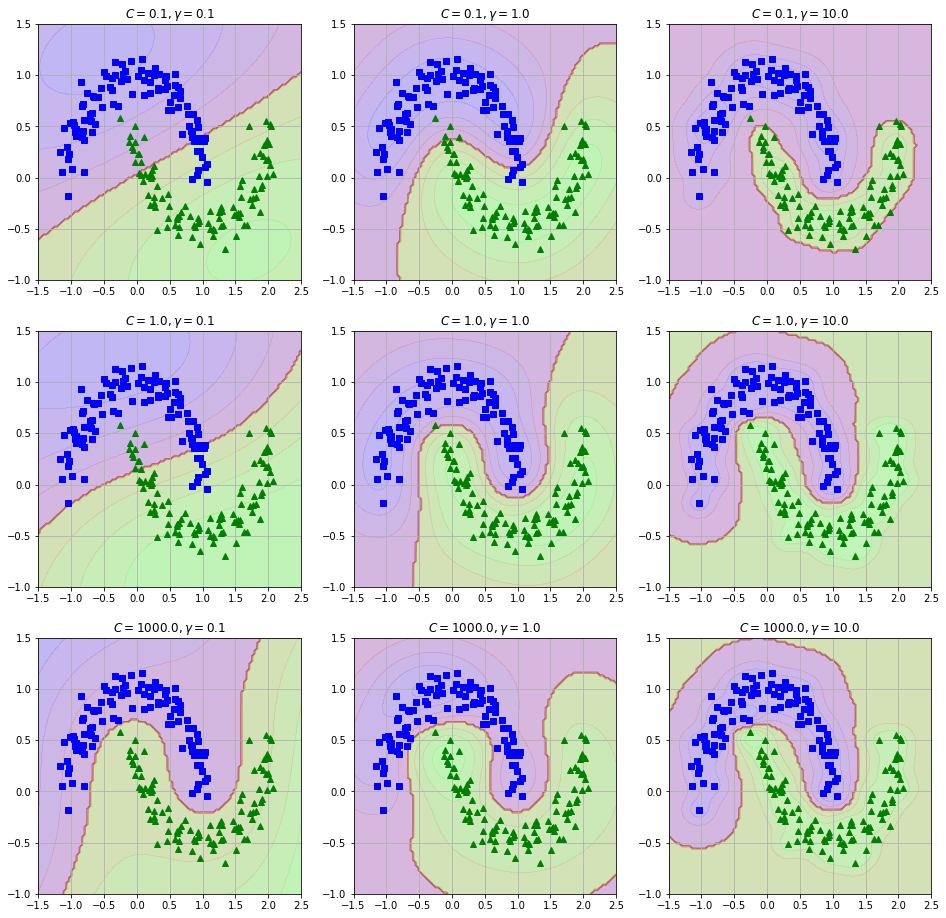

In [ ]:
plt.figure(figsize=(16, 16))
for i, C in enumerate([0.1, 1.0, 1000.]):
    for j, gamma in enumerate([0.1, 1.0, 10.]):
        plt.subplot(3, 3, 3 * i + j + 1)
        model = Pipeline([('scaler', StandardScaler()),
                          ('svm_clf', SVC(kernel='rbf', degree=3, coef0=1, C=C, gamma=gamma))])
        model.fit(X_train, y_train)
        plt.title(r'$C={} , \gamma={}$'.format(C, gamma))
        plot_predictions(model, [-1.5, 2.5, -1, 1.5])
        plot_dataset(X, y, [-1.5, 2.5, -1, 1.5], set_label=False)